In [1]:
#Shishir Khanal
#Continuous to Discrete-time conversion in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html
using Pkg;
Pkg.add("ControlSystems");
Pkg.add("Plots");
using ControlSystems, Plots;

    Updating registry at `C:\Users\Khanalshis\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [2]:
#Consider a CT PID:
#        C(s) = Kₚ + Kᵢ* (1/s) + (N*Kd)/(1 + (N/s))
#Consider a robot joint plant
#        P(s) = 1 / (10s^2 + 0.1s)

function pid_compare(kp, ki, kd, N, Ts, t_f)
    s = tf("s")
    z = tf("z", Ts)
    P = 1 / (10s^2 + 0.1s)
    C_c = kp + ki/s + s*N*kd/(s + N)
    L_c = C_c*P
    T_c = feedback(L_c)
    tvec = collect(Float64, 0:Ts:t_f)
    r = ones(size(tvec))
    y_c,t_c,x_c = step(T_c, tvec) #step response of CT sys
    
    #Plant discretized using bilinear transform
    P_d = (Ts*(z+1)/(2*(z-1)))*(Ts*z+Ts)/((20+0.1*Ts)*z - 20 + 0.1*Ts)
    
    #Controller discretizd using forward difference method
    C_fd = kp + ki*Ts/(z-1) + kd*N*(z-1)/(z-1+N*Ts)
    L_fd = C_fd*P_d
    T_fd = feedback(L_fd)
    y_fd, t_fd, x_fd = step(T_fd, tvec)
    
    #Controller- backward difference method
    C_bd = kp + ki*Ts*z/(z-1) + kd*N*(z-1)/((1+N*Ts)*z-1)
    L_bd = C_bd*P_d
    T_bd = feedback(L_bd)
    y_bd, t_bd, x_bd = step(T_bd, tvec)
    
    #Controller - bilinear transform
    C_bt = kp + ki*Ts*(z+1)/(2*(z-1)) + kd*N*(z-1)/((1+0.5*N*Ts)*z+0.5*N*Ts - 1)
    L_bt = C_bt*P_d
    T_bt = feedback(L_bt)
    y_bt, t_bt, x_bt = step(T_bt, tvec)
    
    y_c = dropdims(y_c, dims=1)
    y_fd = dropdims(y_fd, dims=1)
    y_bd = dropdims(y_bd, dims=1)
    y_bt = dropdims(y_bt, dims=1)
    
    plot(tvec,r,label="Step Ref")
    plot!(tvec,y_c, label="y (continuous)")
    plot!(tvec,y_fd, label="y (forward difference)")
    plot!(tvec,y_bd, label="y (backward difference)")
    plot!(tvec,y_bt, label="y (bilinear difference)", xlabel="time (sec)", ylabel="y(t)",
        title="Step response comparison", legend=:bottomright)
end

pid_compare (generic function with 1 method)

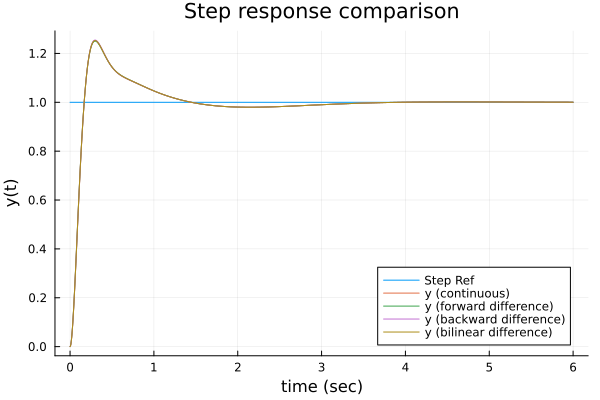

In [3]:
begin
    Ts = 0.001
    kp = 200.0
    ki = 240.0
    kd = 100.0
    t_f = 6
    N = 20.0
    pid_compare(kp, ki, kd, N, Ts, t_f)
end

In [4]:
begin
    s = tf("s")
    C_c = kp + ki/s + s*N*kd / (s+N)
    pole(C_c)
end

2-element Vector{ComplexF64}:
 -20.0 + 0.0im
   0.0 + 0.0im

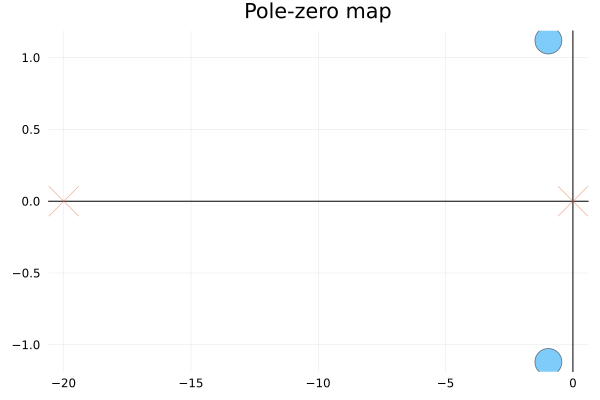

In [5]:
pzmap(C_c)

In [6]:
begin
    z = tf("z", Ts)
    C_fd = kp + ki*Ts / (z+1) + kd*N*(z-1) / (z-1+N*Ts)
    pole(C_fd)
end

2-element Vector{ComplexF64}:
 -1.0 + 0.0im
 0.98 + 0.0im